In [24]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
from datetime import timedelta
import time
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import mplcyberpunk
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
import requests
from bcb import currency
from bcb import sgs
from fpdf import FPDF
from matplotlib.dates import date2num
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [25]:
# # selic = sgs.get(('selic', 432), start = '2022-10-01')
# # selic.plot(figsize = (15, 10))
# # volatilidade_12m_ibov.plot(figsize = (15, 10))
# # plt.title("Dados Ibovespa e S&P500")
#
#
# # Pegando dados do yahoo finance.
#
indices = ['^BVSP', '^GSPC']
hoje = datetime.now()
um_ano_atras = hoje - timedelta(days = 366)
dados_mercado = pdr.get_data_yahoo(indices, start = um_ano_atras, end = hoje)
#
#
# # Pegando fechamento de cada ativo
#
dados_fechamento = dados_mercado['Adj Close']
dados_fechamento.columns = ["Ibov", "S&P500"]
dados_fechamento = dados_fechamento.dropna()
#
#
# # Pegando fechamento mensal e anual para calcular rentabilidades
#
dados_anuais = dados_fechamento.resample("Y").last()
dados_mensais = dados_fechamento.resample("M").last()
#
#
# # Calculando rentabilidades
#
retorno_diario = dados_fechamento.pct_change().dropna()
retorno_mes_a_mes = dados_mensais.pct_change().dropna()
retorno_mes_a_mes = retorno_mes_a_mes.iloc[1: , :]
retorno_no_ano = dados_anuais.pct_change().dropna()
#
#
# # Fechamento de dia
#
fechamento_de_dia = retorno_diario.iloc[-1, :]
#
#
# # Volatilidade ibov e S&P500
#
volatilidade_12m_ibov = retorno_diario['Ibov'].std() * np.sqrt(252)
volatilidade_12m_sp = retorno_diario['S&P500'].std() * np.sqrt(252)

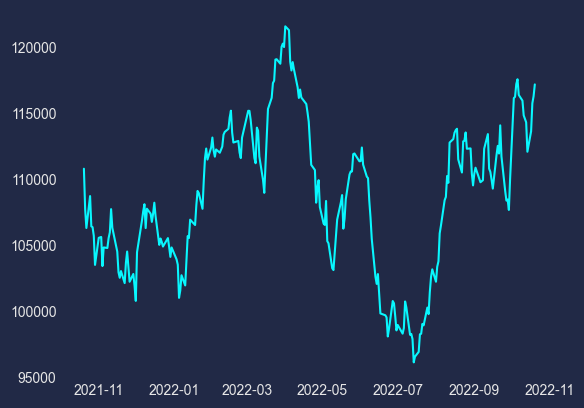

In [26]:
# # Volatilidade ibov
#
fig, ax = plt.subplots()
plt.style.use("cyberpunk")
ax.plot(dados_fechamento.index, dados_fechamento['Ibov'])
ax.grid(False)
plt.savefig('ibov.png', dpi = 300)

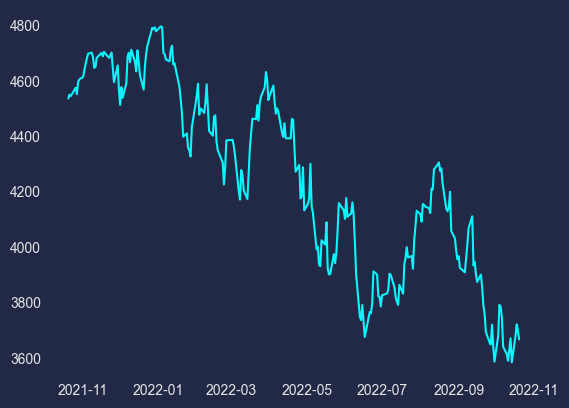

In [27]:
# # Volatilidade S&P500
#
fig, ax = plt.subplots()
plt.style.use("cyberpunk")
ax.plot(dados_fechamento.index, dados_fechamento['S&P500'])
ax.grid(False)
plt.savefig('sp.png', dpi = 300)

In [28]:
# # Pegando os dias úteis com base nas datas de fechamento Ibov vs. S&P500
#
data_inicial = dados_fechamento.index[0]
#
# Timestamp('2021-10-20 00:00:00')
#
if datetime.now().hour < 10:
    data_final = dados_fechamento.index[-1]
else:
    data_final = dados_fechamento.index[-2]
#
# Timestamp('2022-10-19 00:00:00')
#
data_inicial = data_inicial.strftime("%d/%m/%Y")
data_final = data_final.strftime("%d/%m/%Y")

In [29]:
url_mais_att = f'''http://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?
pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data={data_final}
&Mercadoria=DI1'''

url_mais_antiga = f'''http://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?
pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data={data_inicial}
&Mercadoria=DI1'''

display(url_mais_antiga)

'http://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?\npagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data=20/10/2021\n&Mercadoria=DI1'

In [30]:
def pegando_dados_di(url):
   driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()))

   driver.get(url)
   
   local_table = ''' 
   //div[@id = "containerPop"]//div[@id = "pageContent"]//form//table//tbody//tr[3]//td[3]//table
   '''

   local_indice = ''' 
   //div[@id = "containerPop"]//div[@id = "pageContent"]//form//table//tbody//tr[3]//td[1]//table
   '''

   elemento = driver.find_element("xpath", local_table)
   elemento_indice = driver.find_element("xpath", local_indice)

   html_tabela = elemento.get_attribute("outerHTML")
   html_indice = elemento_indice.get_attribute("outerHTML")

   driver.quit()

   tabela = pd.read_html(html_tabela)[0]
   indice = pd.read_html(html_indice)[0]

   return tabela, indice

In [ ]:
di_mais_recente, indice_di_mais_recente = pegando_dados_di(url=url_mais_att)
di_mais_antigo, indice_di_mais_antigo = pegando_dados_di(url=url_mais_antiga)

In [ ]:
display(di_mais_recente)
display(indice_di_mais_recente)